In [1]:
from size_based_ecosystem import *
import imageio
from mpl_toolkits.axes_grid1 import ImageGrid
from utility_functions import *

In [2]:
from scipy.special import lambertw
def detection_dist(light, k, K, c):
    return np.real(2*lambertw(k/2* np.sqrt(light/c*(K+light)))/k)

In [3]:
(solar_input_calculator(normalized = False)*683).max()

79878.12823901525

In [4]:
#plt.plot(ecos[0].spectral.x, detection_dist(l, k, K, c))

In [5]:
tz = 'Europe/Vatican'
name = 'Oresund'
start_date = '2014-04-01'
end_date = '2014-5-01'
freq = '15Min'

In [6]:
dates = pd.date_range(start=start_date, end=end_date, freq=freq, tz=tz)

In [7]:
def dist_plotter(eco, strats, times, filename = None):
    day_interval = 96
    fig, ax = plt.subplots(1,len(times), sharex='col', sharey = 'row')
    fig.set_size_inches((12/2.54, 8/2.54))
    
    
    
    for i, time in enumerate(times):
        ax[i].plot(eco.spectral.x, strats[time][0]@eco.heat_kernels[0], color = 'blue')
        ax[i].plot(eco.spectral.x, strats[time][1]@eco.heat_kernels[0], color = 'red')
    plt.savefig("specific_dists_" + filename + ".pdf")

In [8]:
new_spectral = spectral_method(30, 200)

In [9]:
def expander(old_spectral, new_spectral, transform_vec):
    length = old_spectral.x[-1]
    coeffs = np.linalg.inv(old.spectral.JacobiP_n(2*old_spectral.x/length - 1, 0, 0, old_spectral.n).T) @ transform_vec
    transformer = new_spectral.JacobiP_n(2*new_spectral.x/new_spectral.x[-1] - 1, 0, 0, old_spectral.n).T
    return transformer @ coeffs

In [10]:
solar_levels = solar_input_calculator()
solar_levels = solar_levels/np.max(solar_levels)

In [11]:
def interpolater(spectral, new_points, transform_vec):
    length = spectral.x[-1]
    coeffs = np.linalg.inv(spectral.JacobiP_n(2*spectral.x/length - 1, 0, 0, spectral.n).T) @ transform_vec
    transformer = spectral.JacobiP_n(2*new_points/new_points[-1] - 1, 0, 0, spectral.n).T
    return transformer @ coeffs

In [12]:
import matplotlib.pyplot as plt
import pickle as pkl
import imageio as imageio
frames_path = "images/images" + "{i}.jpg"
gif_path = "images/test_gif.gif"

In [13]:
def data_extractor(filenames, path = 'data/short_time/'):
    strategies = []
    populations = []
    eco = []
    resources = []
    for text in filenames:
        with open(path + 'strategies' + text + '.pkl', 'rb') as f:
            strategies.append(np.array(pkl.load(f)))
        with open(path + 'population' + text + '.pkl', 'rb') as f:
            populations.append(np.array(pkl.load(f)))
        with open(path + 'eco' + text + '.pkl', 'rb') as f:
            eco.append( pkl.load(f))
        with open(path + 'resource' + text + '.pkl', 'rb') as f:
            resources.append(np.array(pkl.load(f)))
    populations[0] = np.array(populations[0])
    populations[1] = np.array(populations[1])
    populations[2] = np.array(populations[2])

    strategies[0] = np.array(strategies[0])
    strategies[1] = np.array(strategies[1])
    strategies[2] = np.array(strategies[2])
    
    
    resources[0] = np.array(resources[0])
    resources[1] = np.array(resources[1])
    resources[2] = np.array(resources[2])
    return strategies, populations, resources, eco


In [14]:
filenames = ['non_random_oresund', 'more_random_oresund', 'completely_random_oresund']

In [15]:
strategies, populations, resources, ecos = data_extractor(filenames)

In [16]:

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size = 14)
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120), 
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150), 
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148), 
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199), 
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)



In [17]:
def heatmap_plotter(data, image_name, ext):
    fig = plt.figure(figsize=(12/2.54, 12/2.54))

    grid = ImageGrid(fig, 111,  # as in plt.subplot(111)
                     nrows_ncols=(1, len(data)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="5%",
                     cbar_pad=0.05,
                     )

    # Add data to image grid
    i = 0
    for ax in grid:
        im = ax.imshow(data[i], vmin=0, cmap='viridis', extent=ext)
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        ax.set_aspect((x1 - x0) / (y1 - y0))
        ax.set_xlabel("(" + str(i+1) + ")" + " Hours")
        ax.set_ylabel("Depth (m)")

        i += 1

    # Colorbar
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    #plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible

    #fig.colorbar(im, cax=cax)

    plt.savefig(image_name+".pdf", bbox_inches='tight')

def bigge_heatmap_plotter(day, eco, strategy_data, fineness = 100, filename = None):
    day_interval = 96
    day = int(day*day_interval)
    new_vec = np.linspace(0,45,fineness)
    HM_C = np.zeros((fineness, 96))
    HM_P = np.zeros((fineness, 96))
    for i in range(day,day+day_interval):
        HM_C[:, i-(day)] = interpolater(eco.spectral, new_vec, strategy_data[i][0]@eco.heat_kernels[0])
        HM_P[:, i-(day)] = interpolater(eco.spectral, new_vec, strategy_data[i][1]@eco.heat_kernels[0])
    heatmap_plotter([HM_C, HM_P], "heatmaps" + filename , [-12, 12, -45, 0])


In [18]:
l = 1000*np.exp(-0.06*ecos[0].spectral.x)
k = 0.06
c = 10**6
K = 10**3

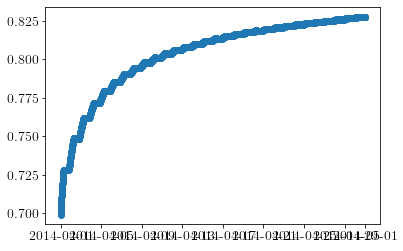

In [19]:
plt.plot_date(dates, np.log10(1+populations[0][:,0]))

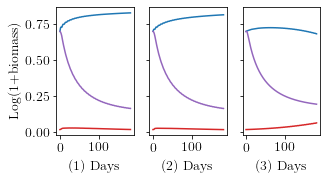

In [20]:
time = np.linspace(0, 180, populations[0].shape[0])




fig, ax = plt.subplots(1, 3, sharex='col', sharey = 'row')
fig.set_size_inches((12/2.54, 6/2.54))

ax[0].plot(time, np.log10(1+populations[0][:,0]), color = tableau20[0], label = '20g fish')
ax[0].plot(time, np.log10(1+populations[0][:,1]), color = tableau20[6], label = '8000g fish')

ax[1].plot(time, np.log10(1+populations[1][:,0]), color = tableau20[0], label = '20g fish')
ax[1].plot(time, np.log10(1+populations[1][:,1]), color = tableau20[6], label = '8000g fish')

ax[2].plot(time, np.log10(1+populations[2][:,0]), color = tableau20[0], label = '20g fish')
ax[2].plot(time, np.log10(1+populations[2][:,1]), color = tableau20[6], label = '8000g fish')

ax[0].plot(time, np.log10(1+ecos[0].spectral.M.sum(axis = 1) @ resources[0].T), color = tableau20[8])
ax[1].plot(time, np.log10(1+ecos[0].spectral.M.sum(axis = 1) @ resources[1].T), color = tableau20[8])
ax[2].plot(time, np.log10(1+ecos[0].spectral.M.sum(axis = 1) @ resources[2].T), color = tableau20[8])

ax[0].set_ylabel("Log(1+biomass)")
ax[0].set_xlabel("(1) Days")
ax[1].set_xlabel("(2) Days")
ax[2].set_xlabel("(3) Days")
plt.savefig("populations.pdf")

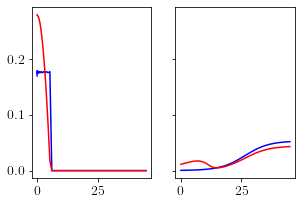

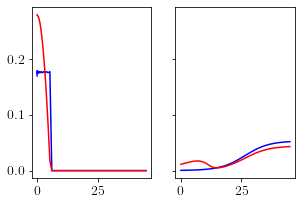

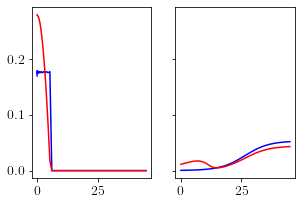

In [29]:
dist_plotter(ecos[0], strategies[0], [96*25, 96*25+48], filename = "rational")
dist_plotter(ecos[0], strategies[0], [96*25, 96*25+48], filename = "semirational")
dist_plotter(ecos[0], strategies[0], [96*25, 96*25+48], filename = "semirational")

In [23]:
ecos[0].water.res_counts/=10

In [24]:
ecos[0].water.res_counts = ecos[0].water.res_counts/10

(0.0, 1.0)

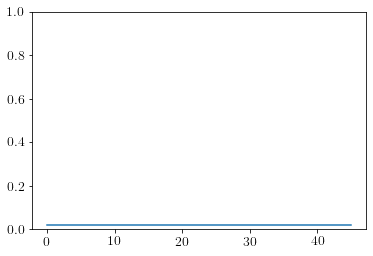

In [25]:
plt.plot(ecos[0].spectral.x, lemke_optimizer(ecos[0])[0:60]@ecos[0].heat_kernels[0])
plt.ylim((0,1))

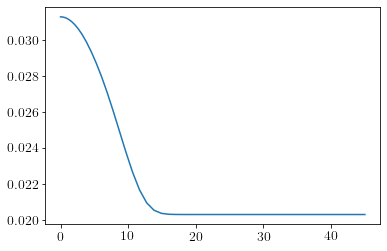

In [26]:
plt.plot(ecos[0].spectral.x, lemke_optimizer(ecos[0])[60:120]@ecos[0].heat_kernels[0])

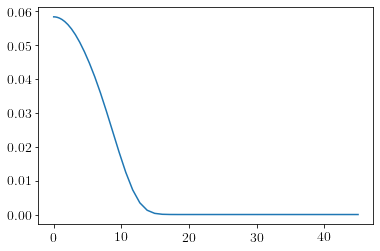

In [27]:
plt.plot(ecos[0].spectral.x, resources[0][-1])

/home/jaem/anaconda3/envs/Siconos/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/home/jaem/anaconda3/envs/Siconos/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar
/home/jaem/anaconda3/envs/Siconos/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use M

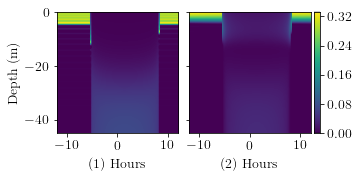

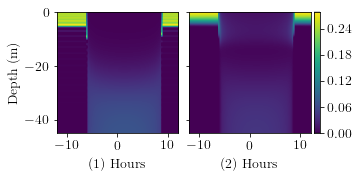

In [28]:
bigge_heatmap_plotter(10, ecos[0], strategies[0], fineness = 200, filename = "day10_semirandom")
bigge_heatmap_plotter(25, ecos[0], strategies[0], fineness = 200, filename = "day90_semirandom")


/home/jaem/anaconda3/envs/Siconos/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


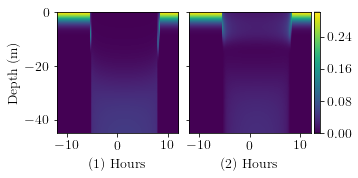

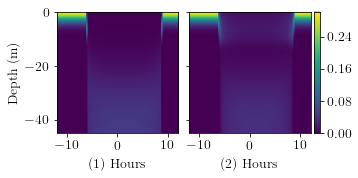

In [30]:
bigge_heatmap_plotter(10, ecos[1], strategies[1], fineness = 200, filename = "day10_semirandom")
bigge_heatmap_plotter(25, ecos[1], strategies[1], fineness = 200, filename = "day90_semirandom")


In [31]:
def short_term_plotter_population(days, eco, solar_levels, populations, resources, strats, filename = None):
    day_interval = 96
    fig, ax = plt.subplots(1, len(days), sharex='col', sharey = 'row')
    fig.set_size_inches((12/2.54, 8/2.54))

    for j, day in enumerate(days):
        
        ax[j].plot(np.linspace(-12,12,day_interval), (populations[day*day_interval:day*day_interval+day_interval,0] - populations[day*day_interval,0])/populations[day*day_interval,0], color = tableau20[0], label = '20g fish')
        ax[j].plot(np.linspace(-12,12,day_interval), (populations[day*day_interval:day*day_interval+day_interval,1] - populations[day*day_interval,1])/populations[day*day_interval,1], color = tableau20[6], label = '8000g fish')

        ax[j].set_xlabel("(" + str(1+j) + ")" + " Hours")

    ax[0].set_ylabel('$\Delta$ Population/Total')

    ax[-1].set_xlim((-12,12))

    plt.savefig("pop_short_"+filename + ".pdf")

In [37]:
def short_term_plotter_growth(days, eco, solar_levels, populations, resources, strats, filename = None):
    day_interval = 96
    fig, ax = plt.subplots(1, len(days), sharex='col', sharey = 'row')
    fig.set_size_inches((12/2.54, 6/2.54))

    for j, day in enumerate(days):
        day_ind = int(day*day_interval)
        eco_params_orig = ecosystem_parameters(eco.parameters.mass_vector, eco.spectral)
        OG_layered_attack = eco_params_orig.layered_attack.copy()
        flows = np.zeros((day_interval, 2))

        flows_more_res = np.zeros((day_interval, 2))

        for i in range(day_ind, day_ind+day_interval):
            layered_attack = new_layer_attack(eco_params_orig, solar_levels[i],  k = 0.2)
            T_G = graph_builder(eco, layered_attack = layered_attack, 
                          populations=populations[i], resources = resources[i],
                          strategies = strats[i])
            flows[i-(day_ind), 0] = T_G[1,0]
            flows[i-(day_ind), 1] = T_G[2,1]
            if np.abs(i-2928)<10**(-3):
                print(T_G)
            
        ax[j].plot(np.linspace(-12,12,day_interval), flows[:,0], color = tableau20[0], label = '20g fish')
        ax[j].plot(np.linspace(-12,12,day_interval), flows[:,1], color = tableau20[6], label = '8000g fish')
        ax[j].set_xlabel("(" + str(1+j) + ")" + " Hours")
        

        
    ax[0].set_ylabel('Growth, $g \cdot year^{-1}$')

    ax[-1].set_xlim((-12,12))

    plt.savefig("growth_short_"+filename + ".pdf")

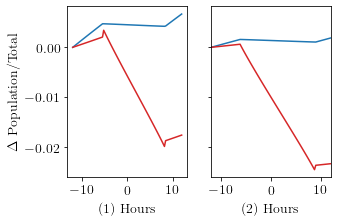

In [39]:
short_term_plotter_population([10, 29], ecos[0], solar_levels, populations[0], resources[0], strategies[0], filename = "rational")

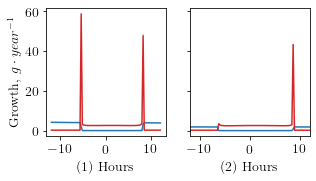

In [40]:
short_term_plotter_growth([10, 29], ecos[0], solar_levels, populations[0], resources[0], strategies[0], filename = "rational")

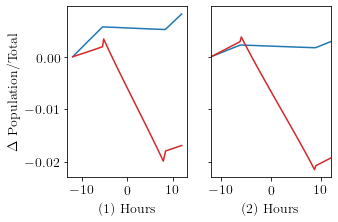

In [35]:
short_term_plotter_population([10, 25], ecos[1], solar_levels, populations[1], resources[1], strategies[1], filename="semi_rational")

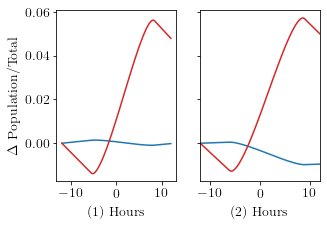

In [36]:
short_term_plotter_population([10, 25], ecos[0], solar_levels, populations[2], resources[2], strategies[2], filename = "irrational")

In [ ]:
new_spectral_obj = spectral_method(30, 120, segments = 1)

In [ ]:
for i in range(day,day+day_interval):
    plt.figure(figsize=(4,4))
    plt.title("Sunlight:" + str(1/2*(1+min(max((2+1)*np.cos(i*2*np.pi/day_interval), -1), 1))))
    plt.plot(eco.spectral.x*3.3, np.diff(np.cumsum(eco.spectral.M @ (strategies[i][0]@eco.heat_kernels[0])), prepend = np.array([0])), color = 'blue')
    plt.plot(eco.spectral.x*3.3, np.diff(np.cumsum(eco.spectral.M @ (strategies[i][1]@eco.heat_kernels[0])), prepend = np.array([0])), color = 'red')
    plt.plot(eco.spectral.x*3.3,  np.diff(np.cumsum(eco.spectral.M @ resources[i]) , append = np.array([0])))
    plt.ylim((0,1))
    plt.savefig("images/images" + str(i) +".jpg")

    plt.close()

In [ ]:
with imgio.get_writer(gif_path, mode='I', fps = 5) as writer:
    for i in range(day, day+day_interval):
        writer.append_data(imgio.imread(frames_path.format(i=i)))

In [ ]:
LD_LA = np.zeros((eco.spectral.n, m_a))
for i in range(day,day+day_interval):
    LD_LA[:, i-(day)] = periodic_layers[i-(day)][:,1,0]
heatmap_plotter([LD_LA], "heatmaps_LA", [0, 24, -100, 0])

In [ ]:
plt.plot(np.log10(np.sum(np.array(resources) @ eco.spectral.M, axis = 1)))

In [ ]:
plt.plot(eco.water.res_counts)

In [ ]:
np.sum(theoretical_max @ eco.spectral.M)